***  
<h1><center>
    miniGAP
</center></h1>    

***  


You can perform all the functions of miniGAP within this notebook or you can create a python script from the last cell of this notebook and run the script in the terminal.

## Initialization Tasks 

Debugging TensorFlow

In [1]:
# This cell gives us a couple options for debugging Tensorflow.
# It is the first code cell, because it must be run, before the TensorFlow library is imported and it is most convenient to import all modules in the next cell
# To enable this debugging, you must change one of the debugging flags to True and run this cell *before* importing running later cells
# Currently this is only done manually from the notebook, but could be included as a JSON setting in the future if desirable

tf_cpu_debugging =False
if tf_cpu_debugging:
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    import tensorflow as tf
    #tf.debugging.set_log_device_placement(True)
    a = tf.constant(1)
    
    if tf.test.gpu_device_name():
        print("GPUs recognized by tensorflow:", tf.config.list_physical_devices('GPU'))
    else:
        print("No GPU found")

tf_gpu_debugging = False
if tf_gpu_debugging:
#     See here for possible option to reset memory github.com/tensorflow/tensorflow/issues/36465
#     import os 
#     os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
    import tensorflow as tf
    tf.debugging.set_log_device_placement(True)
    a = tf.constant(1)
    if tf.test.gpu_device_name():
        print("GPUs recognized by tensorflow:", tf.config.list_physical_devices('GPU'))
    else:
        print("No GPU found")


In [2]:
# This cell performs a couple initialization tasks that have to start before even importing all the libraries or settings
# 1) Defines a version of miniGAP (hardcoded)
# 2) Determines whether this is being run as a notebook or a script with in_notebook(). Some tasks are only performed in the notebook and vice versa.
#    in_notebook() is a function that returns True if this code is run from an ipython kernel or False otherwise
#    I need to do this first, because the following task is performed conditional on this being run as a script
# 3) Times the initial setup of miniGAP if we are running the miniGAP script.
#    Initial setup refers to everything starting with this task up to and including gathering structural info (like energies)
# 4) Import functions and libraries used by miniGAP 
# 5) Determines a path to the miniGAP home directory which can be used for reading or writing files.
# 6) Determines the date for use in naming output files
# 7) Imports a banner to printed at the beginning of script output
# 8) Sets a printing format
# 9) Compiles some functions as tf.functions
# 10) Sets a list of values to be interpreted as Nonetype

version = "0.0.0"

import sys
sys.path.append('../code')
from general_helpers import *
# True if run from ipython kernel or False otherwise
in_notebook = check_if_in_notebook()

# Time initial setup
import time
if not in_notebook:
    TimeBeforeStartUp = time.time()

# import functions
## import functions from my files
from miniGAP_helpers import *
from general_helpers import *
# ideally I wouldn't need to import this
from ASE_helpers import convert_energy, convert_force


## import functions from libraries
import os.path as path
import argparse
import json
from collections import namedtuple
import datetime as dt 
import resource
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import gpflow
from itertools import islice
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
    
# Sets the miniGAP home directory. This assumes the notebook or script is located one directory below the home directory.
if in_notebook:
    miniGAP_parent_directory = "../"
else:
    miniGAP_parent_directory = path.dirname(path.dirname(path.realpath(__file__))) + "/"
    
# Save date for use in naming output files
today = dt.datetime.today()
today_string = "_{:d}_{:02d}_{:02d}".format(today.year, today.month, today.day)
today_string_alt = "{:d}/{:02d}/{:02d}".format(today.year, today.month, today.day)

# Save date for use in naming output files
version_placeholder = "_VERSION_PLACEHOLDER_"
date_placeholder = "_DATE_PLACEHOLDER_"
version_formatted = "{:{str_len}s}".format(version, str_len=len(version_placeholder) )
date_formatted = "{:{str_len}s}".format(today_string_alt, str_len=len(date_placeholder) )
miniGAP_banner_filename = miniGAP_parent_directory + "code/miniGAP_banner.txt"
with open(miniGAP_banner_filename, "r") as banner_file:
    banner = banner_file.read()
banner = banner.replace(version_placeholder, version_formatted).replace(date_placeholder, date_formatted)

# Sets the printing format of gpflow model hyperparameters
if in_notebook:
    gpflow.config.set_default_summary_fmt("notebook")
else:
    gpflow.config.set_default_summary_fmt("grid")
    
# Compiles some functions as TensorFlow tf functions not all of which are currently used
# Compiled tf functions are several times faster than normal functions
mse_tf = tf.function(mse, autograph=False, jit_compile=False)
mse_2factor_tf = tf.function(mse_2factor, autograph=False, jit_compile=False)
train_hyperparams_without_forces_tf = tf.function(train_hyperparams_without_forces, autograph=False, jit_compile=False)
predict_energies_from_weights_tf = tf.function(predict_energies_from_weights, autograph=False, jit_compile=False)

# This could be used to define what input values will be interpretted as None.
# This may be useful if there are common user-input mistakes when setting a value to None from the commandline or JSON input.
# However, I do not use this yet.
nonetypes = [None, "None", "null", ""]

## Input parameters

Some input parameter notes (not comprehensive):

my_priority = #"efficiency" for experimenting with something new or otherwise "consistency"

controls initial train_test_split breaking apart training and test data  
split_seed = 2

controls in-training train_test_split breaking apart training_j and validation_j data  
valid_split_seed = 2

controls multiple tf stochastic processes including:  
1) Adams optimizer AND   
2) batching through tf.data.Dataset.from_tensor_slices in training  
tf_seed = 2

controls batching through tf.data.Dataset.from_tensor_slices in training  
shuffle_seed = 2

kernel_type = #"polynomial" for actual GAP or "exponentiated_quadratic" possibly for debugging  

prediction_calculation = #"direct" OR "predict_f" OR "cholesky" OR "alpha"

import_fraction has priority over n_total  
Therefore, set import_fraction = null to use n_total  
If you are compiling your dataset in any way other than directly importing it, i.e. using MD of some sort,  
then you can only use n_total

n_train has priority over train_fraction  
Therefore, set n_train = null to use train_fraction

In [3]:
# This cell imports settings from the default and user JSON files and saves them to default_JSON_settings_dict and user_JSON_settings_dict respectively
# The setting priority in descending order is: (1) commandline argument, (2) user_settings JSON, (3) default_settings JSON
# Some settings from the JSON files may be overwritten by commandline args for use in the code, but the JSON_settings_dict dictionaries is not edited.
# These disctionaries are currently no longer used after saving them to the namedtuple object (see a few cells down), but they might be useful in the future for debugging.
# Note 1: You can change the input parameters in the JSON file and rerun the notebook starting from here
# Note 2: To debug or reformat the JSON file, I recommend jsonformatter.org
# Note 3: The settings file from which these data are imported has a nested structure. This is exclusively for ease of navigation for the user.
#         The parent settings names such as "debugging_settings" are completely ignored by the code
#         Therefore, you can also use a settings file saved from a previous run, which may not have a nested structure.

settings_json_filename = miniGAP_parent_directory + "code/default_settings.json"
with open(settings_json_filename, encoding = 'utf-8') as settings_file_object:
    default_JSON_settings_dict_nested = json.load(settings_file_object)
default_JSON_settings_dict = flatten_dict(default_JSON_settings_dict_nested)

settings_json_filename = miniGAP_parent_directory + "code/user_settings.json"
with open(settings_json_filename, encoding = 'utf-8') as settings_file_object:
    user_JSON_settings_dict_nested = json.load(settings_file_object)
user_JSON_settings_dict = flatten_dict(user_JSON_settings_dict_nested)


In [4]:
# This cell allows the miniGAP script to accept commandline parameters
# These commandline parameters have priority over the JSON settings
# Most, but not all of the JSON settings can be overwritten using a commandline option

if not in_notebook:
    parser = argparse.ArgumentParser()
    
    # arguments for debugging
    parser.add_argument('--verbose', type=bool, help="Print out details at each step") 
    parser.add_argument('-vt', '--print_timings', type=bool, help="Print out details at each step") 

    # arguments specific to forming dataset (including potentially creating md trajectory)
    parser.add_argument('-sf', '--structure_file', help="Specify a structure file to import. 'None' will be interpretted as using no structure file.")
    parser.add_argument('-cf', '--chemical_formula',  help="If no structure file is supplied, you can specify a single structure here and perform md \
    to generate a trajectory that you will use as your dataset. If neither this nor a structure file are supplied, we will use diatomics.")
    parser.add_argument("-md", '--molecular_dynamics', type=bool, help="Indicate if you want molecular dynamics performed. Will generate diatomic if no structure given")
    # available as a JSON parameter, but commandline argument is buggy
#     parser.add_argument('-mdi', '--md_indices', default=[0], type=int, nargs='*', help="If performing molecular dynamics on a structure file with multiple structures, you can give indices of all structures to perform md on.")
    parser.add_argument('-mdi', '--md_index', type=int, help="If performing molecular dynamics on a structure file with multiple structures, you can give the index of the structure to perform md on.")
    parser.add_argument('-de', '--diatomic_element',  choices = ["N", "O", "H"], help="If generating diatomics, you can specify element")
    parser.add_argument('-dbl', '--diatomic_bond_length',  type=float, help="If generating diatomics, you can specify initial bond length")
    parser.add_argument('-mdt', '--md_temp',  type=float, help="If performing molecular dynamics, specify temperatutre (K) of MD")
    parser.add_argument('-mda', '--md_algorithm',  choices = ["VelocityVerlet", "Berendsen"], type=str, help="If performing molecular dynamics, specify algorithm of MD")
    parser.add_argument('-mts', '--md_time_step',  type=float, help="If performing molecular dynamics, specify time step (fs) of MD")
    parser.add_argument('-mds', '--md_seed',  type=int, help="If performing molecular dynamics, change this seed to get different trajectories")
    parser.add_argument('-mec', '--md_energy_calculator',  choices = ["EMT", "LJ", "Morse"], help = "If performing molecular dynamics, specify ASE energy/force calculator")
    parser.add_argument('-n', '--n_total',  type=int, help="Specify # of md generated structures or # of structures to use from input file")
    parser.add_argument('-ns', '--n_sparse',  type=int, help="Specify # of characteristic sparse point to use")

    # arguments specific to soap
    parser.add_argument('--rcut',  type=float, help= "Choice of SOAP cut off radius")
    parser.add_argument('--nmax',  type=int, help="Choice of SOAP n_max")
    parser.add_argument('--lmax',  type=int, help="Choice of SOAP l_max")

    # arguments specific to learning
    parser.add_argument('-ss', '--split_seed', type=int, help="Random seed for cross-validation")
    parser.add_argument('-tf', '--train_fraction', type=float, help="Specify the fraction of structures used in training")
    parser.add_argument('-ne', '--n_epochs', type=int, help="Number of epochs")

#     some housekeeping
#     parser.add_argument('remainder', nargs=argparse.REMAINDER, help=argparse.SUPPRESS)

    cmdline_args = parser.parse_args()
    cmdline_args_dict = vars(cmdline_args)


In [5]:
# This cell creates a namedtuple variable, 's', which stores all settings. For details on how to use a namedtuple, see next cell.
# If this is run as a script then, prior to creating s, we check if there are commandline arguments.
# Settings from the user_settings.JSON overwrite settings from default_settings.JSON and are stored in the dictionary 'settings_dict'
# Any commandline argument overwrites any argument from a JSON settings file

settings_dict = default_JSON_settings_dict.copy()
settings_dict.update(user_JSON_settings_dict)
# Synchronize the JSON and commandline settings
if not in_notebook:
    for setting_name in settings_dict.keys():
        if setting_name in cmdline_args_dict.keys():
            # I forget why the '!= None' logic is necessary
            if cmdline_args_dict[setting_name] != None:
                settings_dict[setting_name] = cmdline_args_dict[setting_name]
    
    for setting_name in cmdline_args_dict.keys():
        if setting_name not in settings_dict.keys():
            print("The commandline argument {} is currently nonfunctional because it does not exist in the JSON file.".format(setting_name))

# Created the namedtuple variable storing all the settings
# I name the namedtuple settings object with one letter 's' instead of using 'Settings' to minimize disruption of the code
# However, you may need for the variable name and the string assigned to 'typename' to be the same if you are pickling.
# 'typename' is the first parameter of namedtuple() and was 'Settings' when I wrote this comment
SettingsNamespace = namedtuple("Settings", settings_dict.keys())
s = SettingsNamespace(*settings_dict.values())

In [6]:
# Set the flag to True to see a demonstration of how to use a namedtuple variable

demonstrate_named_tuple=False

if demonstrate_named_tuple:
    # You can iterate through the elements of a named_tuple
    # s._fields contains the setting names or fields
    n_settings_to_print = 10
    print("The first {} fields and values within s:".format(n_settings_to_print) )
    for setting_field, setting_value in zip(s._fields[:n_settings_to_print], s[:n_settings_to_print]):
        print("\t{} = {}".format(setting_field, setting_value))
    print("\t...\n")
    
    # You can acccess variables of a named tuple in 2 ways
    print("2 ways of accessing values stored in s:")
    # 1) As an attribute
    print("\t1) s.structure_file = {}".format(s.structure_file) )
    
    # 2) Indexing
    index_for_demonstration = [i for i in range(len(s._fields)) if s._fields[i] == "structure_file"][0]
    print("\t2) s[{}] = {}".format(index_for_demonstration, s[index_for_demonstration]))

    # I exclusively use this method in miniGAP code because this allows me to just prepend 's.' to any variable I had been using 
    #     from my previous code, which defined all variables within a notebook and had no JSON or commandline arg input.
    # Another convenience of using a namedtuple is that I can just replace 's.' with 'self.' in the futurewhen when I convert 
    #     the majority of miniGAP code into a GAP class.

# For more details see docs.python.org/3/library/collections.html#collections.namedtuple

In [7]:
# Print banner in script unless supressed
# Had to wait until we had the suppress setting to do this
if not (in_notebook or s.suppress_banner):
    print(banner, end="")

## Output files

In [8]:
# This cell allows for saving results
# If the user so chooses:
#     1) A new subdirectory will be created for the results output files
#            The new subdirectory is /minigap/results/CALCULATIONTITLE where CALCULATIONTITLE is determined by user input and existing directories
#     2) All output (stdout) printed to terminal is also saved to a file in CALCULATIONTITLE if run from a script
#     3) The settings are saved to a file in CALCULATIONTITLE similar to the JSON input file

if s.make_output_files:
    # Make new subdirectory
    # The name can be given by s.title or it will just be 'results'
    # If s.append_date_to_title is set to True, the date will be added to the end
    # If a directory already exists with the attempted name, the lowest possible integer to make a unique name is added to the end
    calculation_results_directory = make_miniGAP_results_subdirectory(s, date=today_string, miniGAP_parent_directory=miniGAP_parent_directory)
    
    # Start saving output to a log file as well as printing it to the terminal
    # Not currently implemented for notebook, because cells might not be run in order which would create a confusing log
    if not in_notebook:
        log_filename = calculation_results_directory + "miniGAP.log"
        if s.verbose:
            print("Logging all output starting after this message into {}".format(log_filename))  
        logger = Logger(log_filename)
        
        # Place banner as first entry into logfile
        # We had to print to terminal first so we use logfile_only=True to avoid dublication 
        logger.write(banner, logfile_only=True)
    
    # Save settings used for this calculation for future reference
    output_JSON_filename = calculation_results_directory + "miniGAP.settings"    
    with open(output_JSON_filename, 'w', encoding='utf-8') as settings_output_file:
        json.dump(settings_dict, settings_output_file, ensure_ascii=False, indent=4)
    if s.verbose:
        print("Input settings for this calculation stored in {}".format(output_JSON_filename))
else:
    # This variable is not used, but needs to exist for positional arguments
    # Ideally we would handle this differently
    calculation_results_directory = ""



Could not create '../results/Debugging_current_2021_12_17', because it already existed. Created '../results/Debugging_current_2021_12_17_25' instead.
Input settings for this calculation stored in ../results/Debugging_current_2021_12_17_25/miniGAP.settings


## Initialization Tasks (continued)

In [9]:
# This cell handles initialization tasks which could not be completed previously.
# These tasks potentially print out some output depending on the s.verbose setting so they could not be performed
#     1) prior to importing the settings, or
#     2) prior to initiating the logging (or else the outputs would not be logged.) 

# miniGAP uses a lot memory so it is good to allow it access to as much as possible
try:
    resource.setrlimit( resource.RLIMIT_STACK, ( resource.RLIM_INFINITY, resource.RLIM_INFINITY ) )
    if s.verbose:
        print("Stack size set to unlimited")
except:
    print("Warning: Unable to raise stack size limit. Typically miniGAP uses a lot of memory and operates better if you allow the stack size to be unlimited. You can try to do this with the command 'ulimit -s unlimited'")

# Check on GPU availability
if s.verbose:
    print("{} GPU(s) recognized by tensorflow:".format(len(tf.config.list_physical_devices('GPU'))), tf.config.list_physical_devices('GPU'))
    


Stack size set to unlimited
1 GPU(s) recognized by tensorflow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# This cell compiles the structure dataset to be used by miniGAP
# You have several options for how to choosing this dataset:
# 1) Import structure dataset directly from file
# 2) Import a structure from a file and then run an MD simulation with ASE. 
#    The structures in the MD trajectory will be used as the dataset.
# 3) Do not use a file ('"structure_file" : null' in the JSON). Specify the chemical formula of a molecule within the g2 collection and then run an MD simulation with ASE.
#    The structures in the MD trajectory will be used as the dataset.
#    Information about the g2 collection:
#      - https://aip.scitation.org/doi/10.1063/1.473182
#      - https://wiki.fysik.dtu.dk/ase/ase/build/build.html#molecules
# 4) Do not use a file or specify a chemical formula('"structure_file" : null'  and '"chemical_formula" : null' in the JSON).
#    This is like option 3, but the starter molecule will be a diatomic.
#    You can specify the diatomic element and initial bond length in the JSON or commandline arguments.

# Note 1: If you don't include a path in the filename, miniGAP will look in the /minigap/data/ directory 
# Note 2: Currently only the force fields with a native ASE implementation are implemented for MD generation of a dataset.
#         These forcfield are "EMT", "LJ", and "Morse". All perform very poorly for nearly all molecules and structures.
#         An exception is diatomic molecules, for which they capture the most important behavior.
# Note 3: You can see here that I use the function 'TickTock'. The real function is 'CompileStructureList'.
#         'TickTock' is is just for timing purposes. See the next cell for more details.

StructureList, TimeCompileStructures = TickTock(CompileStructureList, s, in_notebook, miniGAP_parent_directory, calculation_results_directory)
if s.print_timings:
    print("Compiling structures into list took {:.2f} seconds".format(TimeCompileStructures))

Imported 600 structures from distorted_propenol.db. Structures were taken uniformly from throughout dataset which contains 2000 total structures.
Compiling structures into list took 0.84 seconds


In [11]:
# You will see the TickTock function used throughout this notebook
# It is a helper function that allows me to time other functions concisely.
# For an example usage set the below flag to True and inspect the code

see_example_of_TickTock_usage = False
if see_example_of_TickTock_usage:
    def example_function(a, b, c="DEFAULT_VALUE", d="DEFAULT_VALUE", function_call_type="normal"):
        summation=0
        for i in range(a):
            summation += b
        print("This {} function call accepted the argument '{}' for the positional parameter 'a'".format(function_call_type, a))
        print("This {} function call accepted the argument '{}' for the positional parameter 'b'".format(function_call_type, b))
        print("This {} function call accepted the argument '{}' for the keyword parameter 'c'".format(function_call_type, c))
        print("This {} function call accepted the argument '{}' for the keyword parameter 'd'".format(function_call_type, d))
        return summation
    
    a_value = 1234567
    b_value = 1
    c_value = "CAT"
    d_value = "DOG"
    
    # You can use the function the normal way:
    normal_function_output = example_function(a_value, b_value, c=c_value, d=d_value, function_call_type="normal")
    print("This normal function call returned {}\n".format(normal_function_output) )
    
    # You can time the function with a slight modification, no extra lines needed
    TickTock_function_output, function_time = TickTock(example_function, a_value, b_value, c=c_value, d=d_value, function_call_type="TickTock")
    print("This TickTock function call returned {}".format(TickTock_function_output) )
    print("This TickTock function call took {:.2f} seconds to run".format(function_time) )
        

In [12]:
# Set convert flag to True and run this cell to convert your file to a database right now from this notebook
# I do not recommend this. The database creation is very slow and will lock you out from running any cells for a long time.
# It is better to do this from a terminal with the script convert_to_db.py
# For example, you can run the command '/relative/path/to/minigap/code/convert_to_db.py structure_file_a.xyz structure_file_b.xyz structure_file_c.xyz'
# This command would create the files structure_file_a.db, structure_file_b.db and structure_file_c.db in your /relative/path/to/minigap/data/ directory
# To overwrite an existing .db file use the --existing_file_behavior flag
# convert_to_db.py --help will explain some more details
convert_to_db_here_and_now = False
if convert_to_db_here_and_now and in_notebook:
    !python ../code/convert_to_db.py $s.structure_file 
    # Use the following line instead of the previous line if you need to overwrite an existing database
    # !python ../code/convert_to_db.py -efb overwrite $s.structure_file

In [13]:
# Set this flag to True if you want to visualize your structure within this jupyter notebook (no pop-up window)
# For more details on the plotting function, refer to the Visualize_Structures notebook

visualize_structure_in_notebook = False

# Having to use (s.save_dataset_animation & s.make_output_files) is tedious
# Perhaps I can make s.make_output_files overwrite s.save_dataset_animation upon import
if visualize_structure_in_notebook or (s.save_dataset_animation & s.make_output_files):
    StructureDatasetAnimation, TimeVisualize = TickTock(CreateMiniGAPVisualization, StructureList, s, calculation_results_directory)
    if visualize_structure_in_notebook and in_notebook:
        display(StructureDatasetAnimation)
    del StructureDatasetAnimation
    
    if s.verbose and (s.save_dataset_animation & s.make_output_files):
        print("Created animation of the structural dataset used in this calculation in the results directory. This might be useful to verify the correct structures are being used.")
    
    if s.print_timings:
        print("Created animation of structures in {:.2f} seconds ".format(TimeVisualize))

In [14]:
# This cell 

[EnergyList, ForceList, PosList, NAtList, EnergyShiftList], TimeGather = TickTock(GatherStructureInfo, StructureList, gather_settings = s)
if s.print_timings:
    gather_forces_message= ", force" if s.use_forces else ""
    print("Gathered energy{} and structure info in {:.2f} seconds".format(gather_forces_message, TimeGather))

Gathered energy, force and structure info in 1.19 seconds


In [15]:
# This cell completes the timing started in the first cell if this code is executed from a script

if s.print_timings and not in_notebook:
    TimeAfterStartUp = time.time()
    TimeStartUp = TimeAfterStartUp - TimeBeforeStartUp
    print("Completed the initial setup of miniGAP (including compiling structural data) in {:.2f} seconds".format(TimeStartUp))

In [16]:
[SoapDerivativeList, SoapList], TimeSoap = TickTock(GenerateDescriptorsAndDerivatives, StructureList, s.nmax, s.lmax, s.rcut, s.smear, s.attach_SOAP_center, s.is_periodic, s.use_forces)
calculate_derivatives_message = " and derivatives" if s.use_forces else ""
if s.print_timings:
    print("Generated SOAP descriptors{} in {:.2f} seconds".format(calculate_derivatives_message, TimeSoap))
elif s.verbose:
    print("Generated SOAP descriptors{}.".format(calculate_derivatives_message))

Generated SOAP descriptors and derivatives in 12.43 seconds


In [17]:
out_data, TimePrepare = TickTock(PrepareDataForTraining, 
                                sp_list=SoapList, 
                                dsp_dx_list = SoapDerivativeList, 
                                en_list = EnergyList,
                                frc_list = ForceList ,
                                pos_list = PosList, 
                                nat_list = NAtList,
                                en_shift_list = EnergyShiftList,
                                prep_settings = s
                                )

if s.print_timings:
    print("Reformatted data to build model in {:.2f} seconds.".format(TimePrepare))

if not s.use_forces:
    train_sps_full, test_sps_full, train_ens, test_ens, train_nats, test_nats, train_en_shfts, test_en_shfts, train_indices, test_indices, train_struct_bools, test_struct_bools, soap_scaler, ens_scaler, ens_var = out_data
else:
    train_sps_full, test_sps_full, train_ens, test_ens, train_nats, test_nats, train_en_shfts, test_en_shfts, train_indices, test_indices, train_struct_bools, test_struct_bools, soap_scaler, ens_scaler, ens_var, train_dsp_dx, test_dsp_dx, train_frcs, test_frcs, frcs_var = out_data 


Split the 600-structure dataset into a 300-structure training dataset and a 300-structure test dataset.
The test dataset will be set aside until the model is trained and ready for prediction.
Reformatted data to build model in 0.10 seconds.


In [18]:
n_samples_full, n_features_full = train_sps_full.shape
SparsifySoapsOutput, TimeSparsify = TickTock( SparsifySoaps, train_soaps = train_sps_full, test_soaps = test_sps_full, train_energies=train_ens, sparsify_samples=s.sparse_gpflow, 
                                    n_samples=s.n_sparse, sparsify_features=s.sparse_features, n_features=s.n_sparse_features, selection_method="PCovCUR",
                                    score_tolerance=1e-5, score_threshold=1e-5, iterative_selection=False, plot_importances=False) 
train_sps, sparse_train_sps, test_sps = SparsifySoapsOutput
if s.sparse_gpflow or s.sparse_features:
    sparsity_samples_message = "" if not s.sparse_gpflow else "samples ({} --> {})".format(n_samples_full, sparse_train_sps.shape[0])
    sparsity_features_message = "" if not s.sparse_features else "features ({} --> {})".format(n_features_full, train_sps.shape[-1])
    sparsity_both_message = " and " if (s.sparse_gpflow and s.sparse_features) else ""
    if s.print_timings:
        print("Sparsified model {}{}{} in {:.2f} seconds.".format( sparsity_samples_message, sparsity_both_message, sparsity_features_message, TimeSparsify) )
    elif s.verbose:
        print("Sparsified model {}{}{}".format( sparsity_samples_message, sparsity_both_message, sparsity_features_message) )
else:
    if s.verbose:
        print("Not using any sparsity.")


Not using any sparsity.


### Future investigations for hyperparameter training
---
1. Does Adam optimizer have problems sometimes within a tf.function?
2. Custom loss function vs optimizer.minimize
3. Set certain variable untrainable

In [19]:
# Initialize kernels and model hyperparameters
tf.random.set_seed(s.tf_seed)

TimeBeforePreEpoch = time.time()


noise_init = 1e-4 #.001# 0.0005499093576274776 #1.625e-4
obs_noise = tf.Variable(noise_init, dtype=s.dtype, name="noise")

degree=2
kernel = pick_kernel(s.kernel_type, amplitude=1, verbose=s.verbose, degree=degree)




# Split training data into training and validation sets
# Now validation set acts as temporary est set
# train_test_split and tensorflow tensors don't get along so I temporarily convert them back to numpy arrays

train_indices_j, valid_indices_j  = train_test_split(np.arange(len(train_sps)), random_state = s.valid_split_seed, test_size=(1-s.valid_fraction))

train_sps_j, valid_sps_j = train_sps[train_indices_j], train_sps[valid_indices_j]
train_ens_j, valid_ens_j = train_ens[train_indices_j], train_ens[valid_indices_j]

if s.use_forces: 
    train_dsp_dx_j, valid_dsp_dx_j = train_dsp_dx[train_indices_j], train_dsp_dx[valid_indices_j]
    train_frcs_j, valid_frcs_j = train_frcs[train_indices_j], train_frcs[valid_indices_j]
    train_nats_j, valid_nats_j = train_nats[train_indices_j], train_nats[valid_indices_j]

# Convert to tensorflow constant tensors
# train_sps_j = tf.constant(train_sps_j, dtype=s.dtype)
# train_ens_j = tf.constant(train_ens_j, dtype=s.dtype)
valid_sps_j = tf.constant(valid_sps_j, dtype=s.dtype)
# valid_ens_j = tf.constant(valid_ens_j, dtype=s.dtype)

if s.sparse_gpflow:
    sparse_train_sps = tf.Variable(sparse_train_sps, shape=sparse_train_sps.shape, dtype=s.dtype, trainable=False)

if s.use_forces:
    train_dsp_dx_j = tf.constant(train_dsp_dx_j, dtype=s.dtype)
    train_frcs_j = tf.constant(train_frcs_j, dtype=s.dtype)    
    valid_dsp_dx_j = tf.constant(valid_dsp_dx_j, dtype=s.dtype)
    valid_frcs_j = tf.constant(valid_frcs_j, dtype=s.dtype)        

test_sps = tf.constant(test_sps, dtype=s.dtype)


# Batch data if  training set is larger than batch_size_max
if len(train_sps_j) < s.batch_size_max:
    iterations_per_epoch = 1
    batch_size = len(train_sps_j)
    if s.verbose:
        print("Training using {} atoms without batching.".format(len(train_sps_j)))
else:
    iterations_per_epoch = int(np.ceil(len(train_sps_j)/s.batch_size_max))
    batch_size = int(np.ceil(len(train_sps_j)/iterations_per_epoch))
    if s.verbose:
        print("Training using {} atoms total using {} batches with {} atoms per batch.".format( len(train_sps_j), iterations_per_epoch, batch_size ))

# training(out_data)
        
TimeBeforeEpoch0 = time.time()


mse_history = []    
hyperparam_history = []



# import warnings
# 
# from gpflow.models import VGP, GPR, SGPR, SVGP
# from gpflow.optimizers import NaturalGradient
# from gpflow.optimizers.natgrad import XiSqrtMeanVar
# from gpflow import set_trainable


if s.my_priority == "efficiency":
    # I don't know what this does
    autotune = tf.data.experimental.AUTOTUNE
    
    
    batches = (
        tf.data.Dataset.from_tensor_slices((train_sps_j, train_ens_j))
        .prefetch(autotune) 
        .shuffle(buffer_size=len(train_sps_j), seed=s.shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )
    
    batch_iterator = iter(batches)

    # I also don't know why we use this
    from gpflow.ci_utils import ci_niter, ci_range
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=s.learn_rate)
    
else:
    batches = (
        tf.data.Dataset.from_tensor_slices((train_sps_j, train_ens_j)) 
        .shuffle(buffer_size=len(train_sps_j), seed=s.shuffle_seed) 
        .repeat(count=None)
        .batch(batch_size)
    )    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=s.learn_rate)
#     optimizer = tf.keras.optimizers.SGD(learning_rate=s.learn_rate)
    
train_hyperparams_without_forces_tf = tf.function(train_hyperparams_without_forces, autograph=False, jit_compile=False)

# new code to make tf.function training work
# --------------------------------------------
train_sps_j_i = tf.Variable(train_sps[:batch_size], shape=(batch_size, train_sps.shape[-1]), dtype=s.dtype, trainable=False )
train_ens_j_i = tf.Variable(train_ens[:batch_size], shape=(batch_size, 1), dtype=s.dtype, trainable=False ) 
if s.sparse_gpflow:
    if sparse_train_sps.shape[0] >= batch_size:
        print("Warning: Batch size is not greater than sparse soap size.\nThis may cause errors in the predict_f function which assumes the inducing points to be fewer than the data points.")
    if s.my_priority == "efficiency":
        gpr_model = gpflow.models.SVGP( kernel=kernel, likelihood=gpflow.likelihoods.Gaussian(),  inducing_variable=sparse_train_sps)
        gpr_model.likelihood.variance.assign(obs_noise)
        gpflow.set_trainable(gpr_model.q_mu, False)
        gpflow.set_trainable(gpr_model.q_sqrt, False)
    else:
        gpr_model = gpflow.models.SGPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel, noise_variance=obs_noise, inducing_variable=sparse_train_sps)
else:
    if s.my_priority == "efficiency":
        # it seems I cannot use  noise_variance=obs_noise for this which makes it not GAP...
        gpr_model = gpflow.models.VGP( data=(train_sps_j_i, train_ens_j_i), kernel=kernel, likelihood=gpflow.likelihoods.Gaussian())
    else:
        gpr_model = gpflow.models.GPR( data=(train_sps_j_i, train_ens_j_i), kernel=kernel, noise_variance=obs_noise)
# --------------------------------------------


print_frequency = max(s.min_print_frequency, int(s.n_epochs/10))

if s.my_priority == "efficiency":
    hyperparam_history.append([(0, np.exp(var.numpy() )) for var in gpr_model.trainable_variables])  
    gpr_objective = gpr_model.training_loss_closure(batch_iterator,  compile=True)
    for j in range(ci_niter(s.n_epochs)):
        if not j % print_frequency:
            print("Epoch {}".format(j))
        optimizer.minimize(gpr_objective, var_list=gpr_model.trainable_variables)
        mse_history.append((j+1, gpr_model.elbo(data=(train_sps, train_ens))))
        hyperparam_history.append([(j+1, np.exp(var.numpy()) ) for var in gpr_model.trainable_variables]) 
    #optimizer.minimize(gpr_model.training_loss, gpr_model.trainable_variables, options=dict(maxiter=s.n_epochs))
        
elif s.my_priority == "consistency":

    hyperparam_history.append([(0, var.numpy()) for var in gpr_model.trainable_parameters])  
    for j in range(s.n_epochs):
        if not j % print_frequency:
            print("Epoch {}".format(j))
            #print(" ".join(["{} = {:.2e} ".format(var.name, np.exp(var.numpy())) for var in trainable_variables]))

        mse_ens_j = 0
        for i, (train_sps_j_i, train_ens_j_i) in enumerate(islice(batches, iterations_per_epoch)):
            if not s.use_forces: #and not s.sparse_gpflow :
                gpr_model.data[0].assign(train_sps_j_i)
                gpr_model.data[1].assign(train_ens_j_i)        
                mse_ens_j_i = train_hyperparams_without_forces_tf(gpr_model, valid_sps_j, valid_ens_j, optimizer)
                print("valid_ens[:3] = {}".format( valid_ens_j[:3].flatten()) )
#                 print(mse_ens_j_i.numpy(), valid_ens_j[:3].numpy().flatten(), train_ens_j_i[:3].numpy().flatten()  )


            else:
                print("Using older approach (not converted to tf.function yet)")
                with tf.GradientTape() as tape:
                    with tf.GradientTape(watch_accessed_variables=False) as tape_sps:
                        tape_sps.watch(valid_sps_j)
                        if s.sparse_gpflow:
                            gpr_model = gpflow.models.SGPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel, inducing_variable=sparse_train_sps)
    #                         gpflow.set_trainable(gpr_model.inducing_variable, False)
                            if i < 3:
                                print_summary(gpr_model)            
                        else:
                            gpr_model.data[0].assign(train_sps_j_i)
                            gpr_model.data[1].assign(train_ens_j_i)
                            #gpr_model = gpflow.models.GPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel)
                        #gpr_model.likelihood.variance.assign(obs_noise)                
                        predict_ens_j_i = gpr_model.predict_f(valid_sps_j)[0]

        #                 gpr_model = gpflow.models.GPR(data=(sps_j_i, train_ens_j_i), kernel=kernel_gpf)
        #                 gpr_model.likelihood.variance.assign(obs_noise_gpf)
        #                 predict_ens_j_i_gpf = gpr_model.predict_f(valid_sps_j)

                    if s.use_forces:
                        predict_d_ens_j_i = tape_sps.gradient(predict_ens_j_i, valid_sps_j)
                        # In the following line I needed to include '* n_atoms' after breaking energies into local energies
                        # The reason is that I am effectively breaking the connection between E and F when breaking energies into local energies
                        # F = -dE/dx =/= -dE_local/dx where E_local = E/n_atoms - E_free
                        # When I split energies into local energies I initially calculated -dE_local/dx which is -dE/dx / n_atoms
                        # We can't just rescale the validation_frcs beforehand, by dividing them by n_atoms, because this 
                        # rescales their weight in the mse by n_atoms which
                        # would lead to forces from smaller structures being overweighted in importances to mse
#                         print(valid_dsp_dx_j.shape, predict_d_ens_j_i.shape, valid_nats_j.shape)
#                         print(valid_nats_j)
                        predict_frcs_j_i = -1*np.einsum('ijk,ik->ij', valid_dsp_dx_j, predict_d_ens_j_i)  * valid_nats_j
                        mse_j_i = mse_2factor_tf(predict_ens_j_i, valid_ens_j, 1/ens_var,
                                                predict_frcs_j_i, valid_frcs_j, 1/frcs_var)
                        mse_ens_j_i = mse_tf(predict_ens_j_i, valid_ens_j)
                    else:
                        mse_j_i = mse_tf(predict_ens_j_i, valid_ens_j)
                        mse_ens_j_i = mse_j_i


        #         grads = tape.gradient(mse_j_i, trainable_variables)
        #         optimizer.apply_gradients(zip(grads, trainable_variables))
                grads = tape.gradient(mse_j_i, gpr_model.trainable_variables)
                # print(gpr_model.trainable_variables[0])#grads[0])
                optimizer.apply_gradients(zip(grads, gpr_model.trainable_variables))
                if i < 3:
                    print_summary(gpr_model)

                if not gpr_model.data[0][0,0].numpy() == train_sps_j_i[0,0].numpy() :
                    print("ERRORERRORERRORERRORERRORERRORERROR")

            print("Adding mse_ens_j_i to mse_ens_j: {} + {} = {} ".format(mse_ens_j_i.numpy(), mse_ens_j , mse_ens_j_i.numpy() + mse_ens_j  ))
            mse_ens_j += mse_ens_j_i

        mse_ens_j /= iterations_per_epoch
        print("Epoch {},  mse = {}".format(j, mse_ens_j))
        mse_history.append((j+1, mse_ens_j))
        hyperparam_history.append([(j+1, var.numpy()) for var in gpr_model.trainable_parameters])    
else:
    print("{} is not a reconized value for my_priority.\n Training did not occur.".format(s.my_priority))



TimeBeforeWeights = time.time()


2021-12-17 02:19:56.876170: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-17 02:19:57.453778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9967 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:01:00.0, compute capability: 7.0
2021-12-17 02:19:57.628665: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Using a degree 2 polynomial kernel.
Alert: Double check the training validity for degree =/= 1 when not using predict_f
Training using 2700 atoms without batching.


In [20]:

TimeBeforeWeights = time.time()
print("Calculating weights")

if s.my_priority == "efficiency" and s.sparse_gpflow == True:
    gpr_model = gpr_model
elif s.my_priority == "consistency":
    if s.sparse_gpflow:
        gpr_model = gpflow.models.SGPR(data=(train_sps, train_ens), kernel=kernel, noise_variance = gpr_model.likelihood.variance, inducing_variable  = sparse_train_sps)
    else:
        gpr_model = gpflow.models.GPR( data=(train_sps, train_ens), kernel=kernel, noise_variance = gpr_model.likelihood.variance)      

print_summary(gpr_model)

if s.sparse_gpflow:
    if s.prediction_calculation in ("direct", "cholesky"):
        print("Alert: {} prediction approach not implemented for sparse model. Using alpha approach instead.".format(s.prediction_calculation))
        trained_weights = gpr_model.posterior().alpha
    elif s.prediction_calculation == "alpha":
        print("Attempting to calculate trained weights using alpha method for sparse gpr model.")
        trained_weights = gpr_model.posterior().alpha
        print("Successfully calculated trained weights using alpha method for sparse gpr model.")
else:
    if s.prediction_calculation in ("direct", "cholesky"):
        KNN = gpr_model.kernel(train_sps)
        KNN_diag = tf.linalg.diag_part(KNN)
        variance_diag = tf.fill(tf.shape(KNN_diag), gpr_model.likelihood.variance)
        KNN_plus_variance = tf.linalg.set_diag(KNN, KNN_diag + variance_diag)
        if s.prediction_calculation == "direct":
            KNN_inv =  tf.linalg.inv(KNN_plus_variance)
            trained_weights = tf.matmul(KNN_inv, train_ens)
        else:
            LNN = tf.linalg.cholesky(KNN_plus_variance)
            LNN_inv = tf.linalg.inv(LNN)
            KNN_inv_from_L = tf.matmul(LNN_inv, LNN_inv,transpose_a=True)
            trained_weights = tf.matmul(KNN_inv_from_L, train_ens)
    elif s.prediction_calculation == "alpha":
        print("ERROR: alpha not implemented for gpflow GPR. Skipping prediction")
    
TimeAfterTraining = time.time()


with tf.GradientTape(watch_accessed_variables=False) as tape_sps:
    tape_sps.watch(test_sps)  
    print("Predicting final energies")
    if s.prediction_calculation == "predict_f":
        predict_ens, predict_ens_var = gpr_model.predict_f(test_sps)
    else:
        if s.sparse_gpflow:
            predict_ens = tf.reshape( predict_energies_from_weights_tf(trained_weights, sparse_train_sps, test_sps, degree), [-1,1])
        else:
            predict_ens = tf.reshape( predict_energies_from_weights_tf(trained_weights,        train_sps, test_sps, degree), [-1,1])
    
if s.use_forces:
    print("Predicting final forces")    
    predict_d_ens = tape_sps.gradient(predict_ens, test_sps)
    predict_frcs = -1*np.einsum('ijk,ik->ij', test_dsp_dx, predict_d_ens) * test_nats

TimeAfterPrediction = time.time()


Calculating weights


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.degree,Parameter,Identity,,False,(),float64,2
GPR.kernel.offset,Parameter,Softplus,,False,(),float64,2.22507e-308
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0001


Predicting final energies
Predicting final forces


2021-12-17 02:19:58.307640: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55a84a208c70


In [21]:
# rescale
test_ens_rescaled = ens_scaler.inverse_transform(test_ens).flatten()
predict_ens_rescaled = ens_scaler.inverse_transform(predict_ens).flatten()
# convert to final units if necessary
test_ens_rescaled = convert_energy(test_ens_rescaled, "eV", s.output_energy_units)
predict_ens_rescaled = convert_energy(predict_ens_rescaled, "eV", s.output_energy_units)
# isolated energies to be added back a the end
train_en_shfts = convert_energy(train_en_shfts, "eV", s.output_energy_units)
test_en_shfts = convert_energy(test_en_shfts, "eV", s.output_energy_units)

if s.prediction_calculation == "predict_f":
    # rescale
    predict_ens_var_rescaled =  np.array(predict_ens_var * ens_scaler.scale_ **2).flatten()
    # convert to final units if necessary
    # Apply the conversion twice to account because the energy variance has units of energy squared
    predict_ens_var_rescaled = convert_energy(predict_ens_var_rescaled, "eV", s.output_energy_units)
    predict_ens_var_rescaled = convert_energy(predict_ens_var_rescaled, "eV", s.output_energy_units)
    
if s.use_forces:
    # rescale
    test_frcs_rescaled = test_frcs * ens_scaler.scale_
    predict_frcs_rescaled = predict_frcs * ens_scaler.scale_
    # convert to final units if necessary
    test_frcs_rescaled = convert_force(test_frcs_rescaled, "eV/ang", s.output_force_units)
    predict_frcs_rescaled = convert_force(predict_frcs_rescaled, "eV/ang", s.output_force_units)

In [22]:
# make a regroup function
# test_ens_regrouped = test_ens_rescaled.reshape(-1, len(StructureList[0]))
# predict_ens_regrouped = predict_ens_rescaled.reshape(-1, len(StructureList[0]))
# self_energies_regrouped = [[self_energy(atom.symbol, use_librascal_values=s.use_self_energies) for atom in StructureList[i]] for i in test_indices]
# test_global_ens = np.sum(test_ens_regrouped + self_energies_regrouped, axis=1)
# predict_global_ens = np.sum(predict_ens_regrouped + self_energies_regrouped, axis=1)
test_global_ens = (test_struct_bools @ test_ens_rescaled ).flatten() + test_en_shfts
predict_global_ens = ( test_struct_bools @ predict_ens_rescaled ).flatten() + test_en_shfts
test_global_nats = NAtList[test_indices]

In [23]:
TrainingCellNonEpochsTraining = TimeBeforeEpoch0 - TimeBeforePreEpoch + TimeAfterTraining - TimeBeforeWeights 
if s.n_epochs:
    TimePerEpoch = (TimeBeforeWeights - TimeBeforeEpoch0)/s.n_epochs
else:
    TimePerEpoch = "N/A"
PredictionTime = TimeAfterPrediction - TimeAfterTraining

if s.print_timings:
    print("{:50s}: {:.3f}".format("Training time outside of epochs in training cell", TrainingCellNonEpochsTraining))
    if s.n_epochs:
        print("{:50s}: {:.3f}".format( "Training time per epoch", TimePerEpoch))
    print("{:50s}: {:.3f}".format("Prediction time", PredictionTime) )



Training time outside of epochs in training cell  : 0.937
Prediction time                                   : 0.572


In [24]:
if True:
    if 'mse_history_by_n' not in locals():
        mse_history_by_n = {}
    if 'hyperparam_history_by_n' not in locals():
        hyperparam_history_by_n = {}

    hyperparam_history_by_n[s.n_total] = hyperparam_history
    mse_history_by_n[s.n_total] = mse_history

    print("Stored the hyperparameters and mse values for plotting under n={}".format(s.n_total) )

Stored the hyperparameters and mse values for plotting under n=600


The title axes are not assigned correctly. Currently fixing.


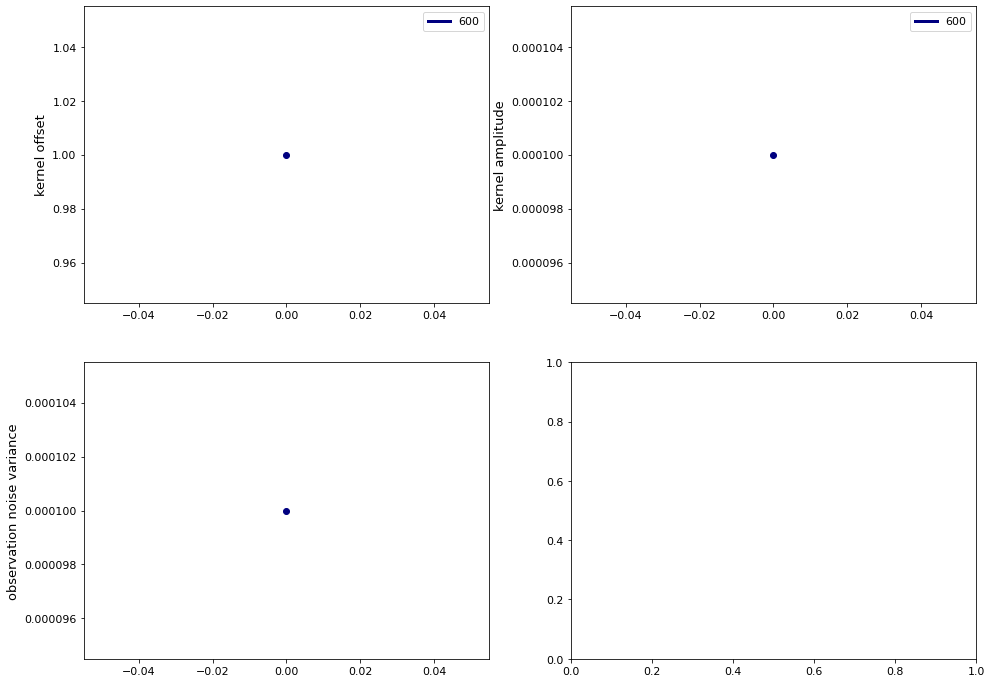

In [25]:
plot_hyperparam_training = (in_notebook or s.n_epochs > 0)

if plot_hyperparam_training:

    palette = plt.get_cmap('gist_ncar')#'nipy_spectral')#"viridis")
    palette_size = palette.N#len(palette.colors)
    palette_itr = 0

    fig, [[ax00, ax01], [ax10, ax11]] = plt.subplots(nrows=2, ncols = 2, figsize=(16,12))

    hyperparam_names = ["kernel offset", "kernel amplitude", "observation noise variance"]

    for n in np.sort(list(mse_history_by_n.keys())):
        mse_history = mse_history_by_n[n]
        hyperparam_history = hyperparam_history_by_n[n]
        if not len(hyperparam_history):
            continue
        color = palette(palette_itr)
        palette_itr = (palette_itr + 30) % palette_size
        print("The title axes are not assigned correctly. Currently fixing.")


        # hyperparameters on axes 00, 01, 10
        hyperparams = np.swapaxes(hyperparam_history, 0, 1)

        ax00.plot(*zip(*hyperparams[0]), color=color, label="{}".format(n), lw=3)
        ax00.plot(*hyperparams[0][-1], "o", color=color)
        label00 = hyperparam_names[0]
        ax00.set_ylabel("{}".format(label00))
    #     #ax00.set_yscale('log')
    #     annotation00 = ax00.annotate('{:.1f}'.format(amplitudes[-1][1]) , xy=amplitudes[-1], xycoords='data', xytext=(-30,100),
    #                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
        ax00.legend()
        ax00.ticklabel_format(useOffset=False)

        ax01.plot(*zip(*hyperparams[1]), color=color, label="{}".format(n), lw=3)
        ax01.plot(*hyperparams[1][-1], "o", color=color)
        label01 = hyperparam_names[1]
        ax01.set_ylabel("{}".format(label01))
    #     #ax01.set_yscale('log')
    #     annotation01 = ax01.annotate('{:.1f}'.format(lengths[-1][1]) , xy=lengths[-1], xycoords='data', xytext=(100,-30), 
    #                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
        ax01.legend()
        ax01.ticklabel_format(useOffset=False)

        ax10.plot(*zip(*hyperparams[-1]), color=color, label="{}".format(n), lw=3)
        ax10.plot(*hyperparams[-1][-1], "o", color=color)
        label10 = hyperparam_names[-1]
        ax10.set_ylabel("{}".format(label10))
        #ax10.set_yscale('log')
    #     annotation01 = ax10.annotate('{:.1e}'.format(noises[-1][1]) , xy=noises[-1], xycoords='data', xytext=(-30,100),
    #                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
    #     ax10.legend()
        ax10.ticklabel_format(useOffset=False)

        if not len(mse_history):
            continue

        #loss on axis 11
        ax11.plot(*zip(*mse_history), color = color, label="{}".format(n), lw=3)
        ax11.plot(*mse_history[-1], "o", color=color)
        #ax11.set_yscale('log')
        bottom, top = ax11.get_ylim()
        bottom2, top2 = ax11.get_ylim()
        ax11.set_ylabel("mse")
        ax11.legend()
        ax11.ticklabel_format(useOffset=False)

        #fig.suptitle("{}".format(s.n_total))
        
        if s.make_output_files:
            hyperparameter_results_filename = "hyperparameter_training"
            plt.savefig(calculation_results_directory + hyperparameter_results_filename)    

Our observation noise variance implies our reference error is +/- 0.25 /atom
Calculated the following error statistics: ('rmse', 'mae', 'mxae', 'r2', 'logvae', 'm', 'b')
Calculated the following error statistics: ('rmse', 'mae', 'mxae', 'r2', 'logvae', 'm', 'b')
Calculated the following error statistics: ('rmse', 'mae', 'mxae', 'r2', 'logvae', 'm', 'b')
Checking if outliers exists among energy predictions.
Outliers of error defined to exist outside the range (25th percentile - 1.5*25th-75th percentile range, 75th percentile + 1.5*25th-75th percentile range), i.e. (-0.25, 0.27).
Additionally, error was not considered an outlier if it fell outside that range, but was within 0.2 * 25th-75th percentile range ( = 0.03) of non-outlier error
11/300 error were found to be outliers.
Cropping energy plots determined to be unnecessary.


,Global Energy,Global Energy/Atom,Local Energy
Units,eV,eV/Atom,eV/Atom
Root Mean Squared Error,0.116966,0.011697,0.020126
Mean Absolute Error,0.086819,0.008682,0.013017
Max Absolute Error,0.415122,0.041512,0.419133
r²,0.975767,0.975767,0.999999
Variance of Log Absolute Error,1.43342,1.43342,1.486564
Linear Fit Slope,0.94466,0.94466,0.999988
Linear Fit y-Intercept,-16.072586,-1.607259,-0.000207


Filename '../results/Debugging_current_2021_12_17_25/energy_prediction_plots.png' selected.
Filename '../results/Debugging_current_2021_12_17_25/energy_errors.csv' selected.


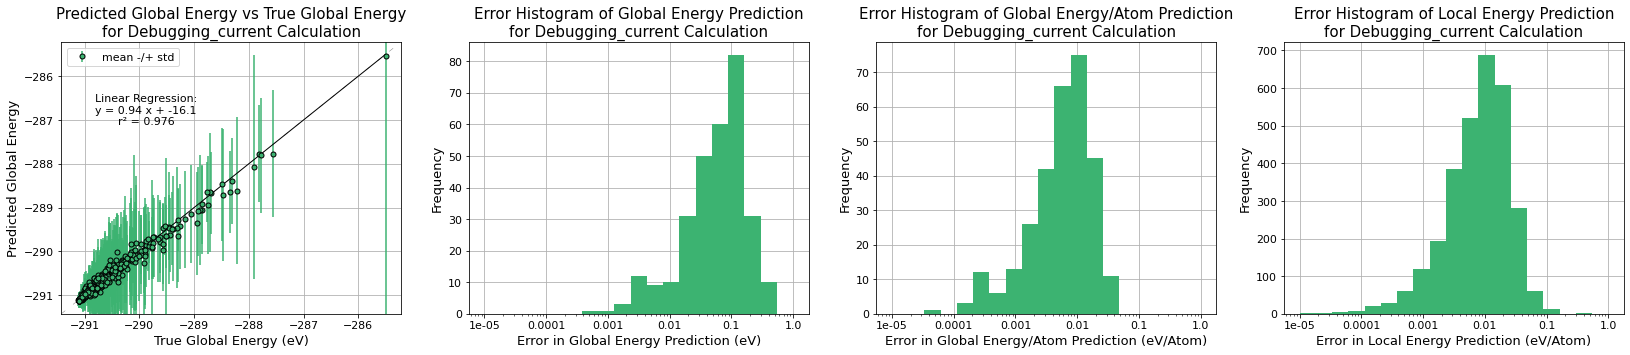

In [26]:
# Print outputs
if s.prediction_calculation == "predict_f":
    predict_global_ens_var = (test_struct_bools @ predict_ens_var_rescaled ).flatten()
    predict_global_ens_std = predict_global_ens_var ** 0.5 
    input_std = (gpr_model.likelihood.variance.numpy() * ens_scaler.scale_[0] **2) ** 0.5
    print("Our observation noise variance implies our reference error is +/- {:.3} /atom".format( input_std) )
else:
    predict_global_ens_std = None

# Creates plots and tables
AnalyzeEnergyResults(test_global_ens, predict_global_ens, s,
                true_local_ens = test_ens_rescaled, predicted_local_ens = predict_ens_rescaled,
                predicted_stdev=predict_global_ens_std, n_atoms = test_global_nats, in_notebook=in_notebook, output_directory=calculation_results_directory)

Calculated the following error statistics: ('rmse', 'mae', 'mxae', 'r2', 'logvae', 'm', 'b')
Checking if outliers exists among Cartesian force components predictions.
Outliers of error defined to exist outside the range (25th percentile - 1.5*25th-75th percentile range, 75th percentile + 1.5*25th-75th percentile range), i.e. (-2.17, 2.15).
Additionally, error was not considered an outlier if it fell outside that range, but was within 0.2 * 25th-75th percentile range ( = 0.22) of non-outlier error
23/9000 error were found to be outliers.
Checking if outliers exists among force magnitude predictions.
Outliers of error defined to exist outside the range (25th percentile - 1.5*25th-75th percentile range, 75th percentile + 1.5*25th-75th percentile range), i.e. (-1.86, 3.69).
Additionally, error was not considered an outlier if it fell outside that range, but was within 0.2 * 25th-75th percentile range ( = 0.28) of non-outlier error
16/3000 error were found to be outliers.
Checking if outlie

,Fx,Fy,Fz,|F|,θ
Units,eV/ang,eV/ang,eV/ang,eV/ang,°
Root Mean Squared Error,1.487743,1.276502,0.790773,1.587271,24.949829
Mean Absolute Error,1.062307,0.916871,0.512427,1.179891,15.897811
Max Absolute Error,11.125995,10.641485,12.608341,10.559823,140.449575
r²,0.577737,0.556417,0.687255,0.554367,0.411195
Variance of Log Absolute Error,1.426787,1.575832,1.864177,1.467113,1.820893
Linear Fit Slope,1.136347,1.242549,1.089803,0.998377,0.612625
Linear Fit y-Intercept,-0.099081,0.064447,0.003114,1.013527,34.911679


Filename '../results/Debugging_current_2021_12_17_25/force_prediction_plots.png' selected.
Filename '../results/Debugging_current_2021_12_17_25/force_errors.csv' selected.


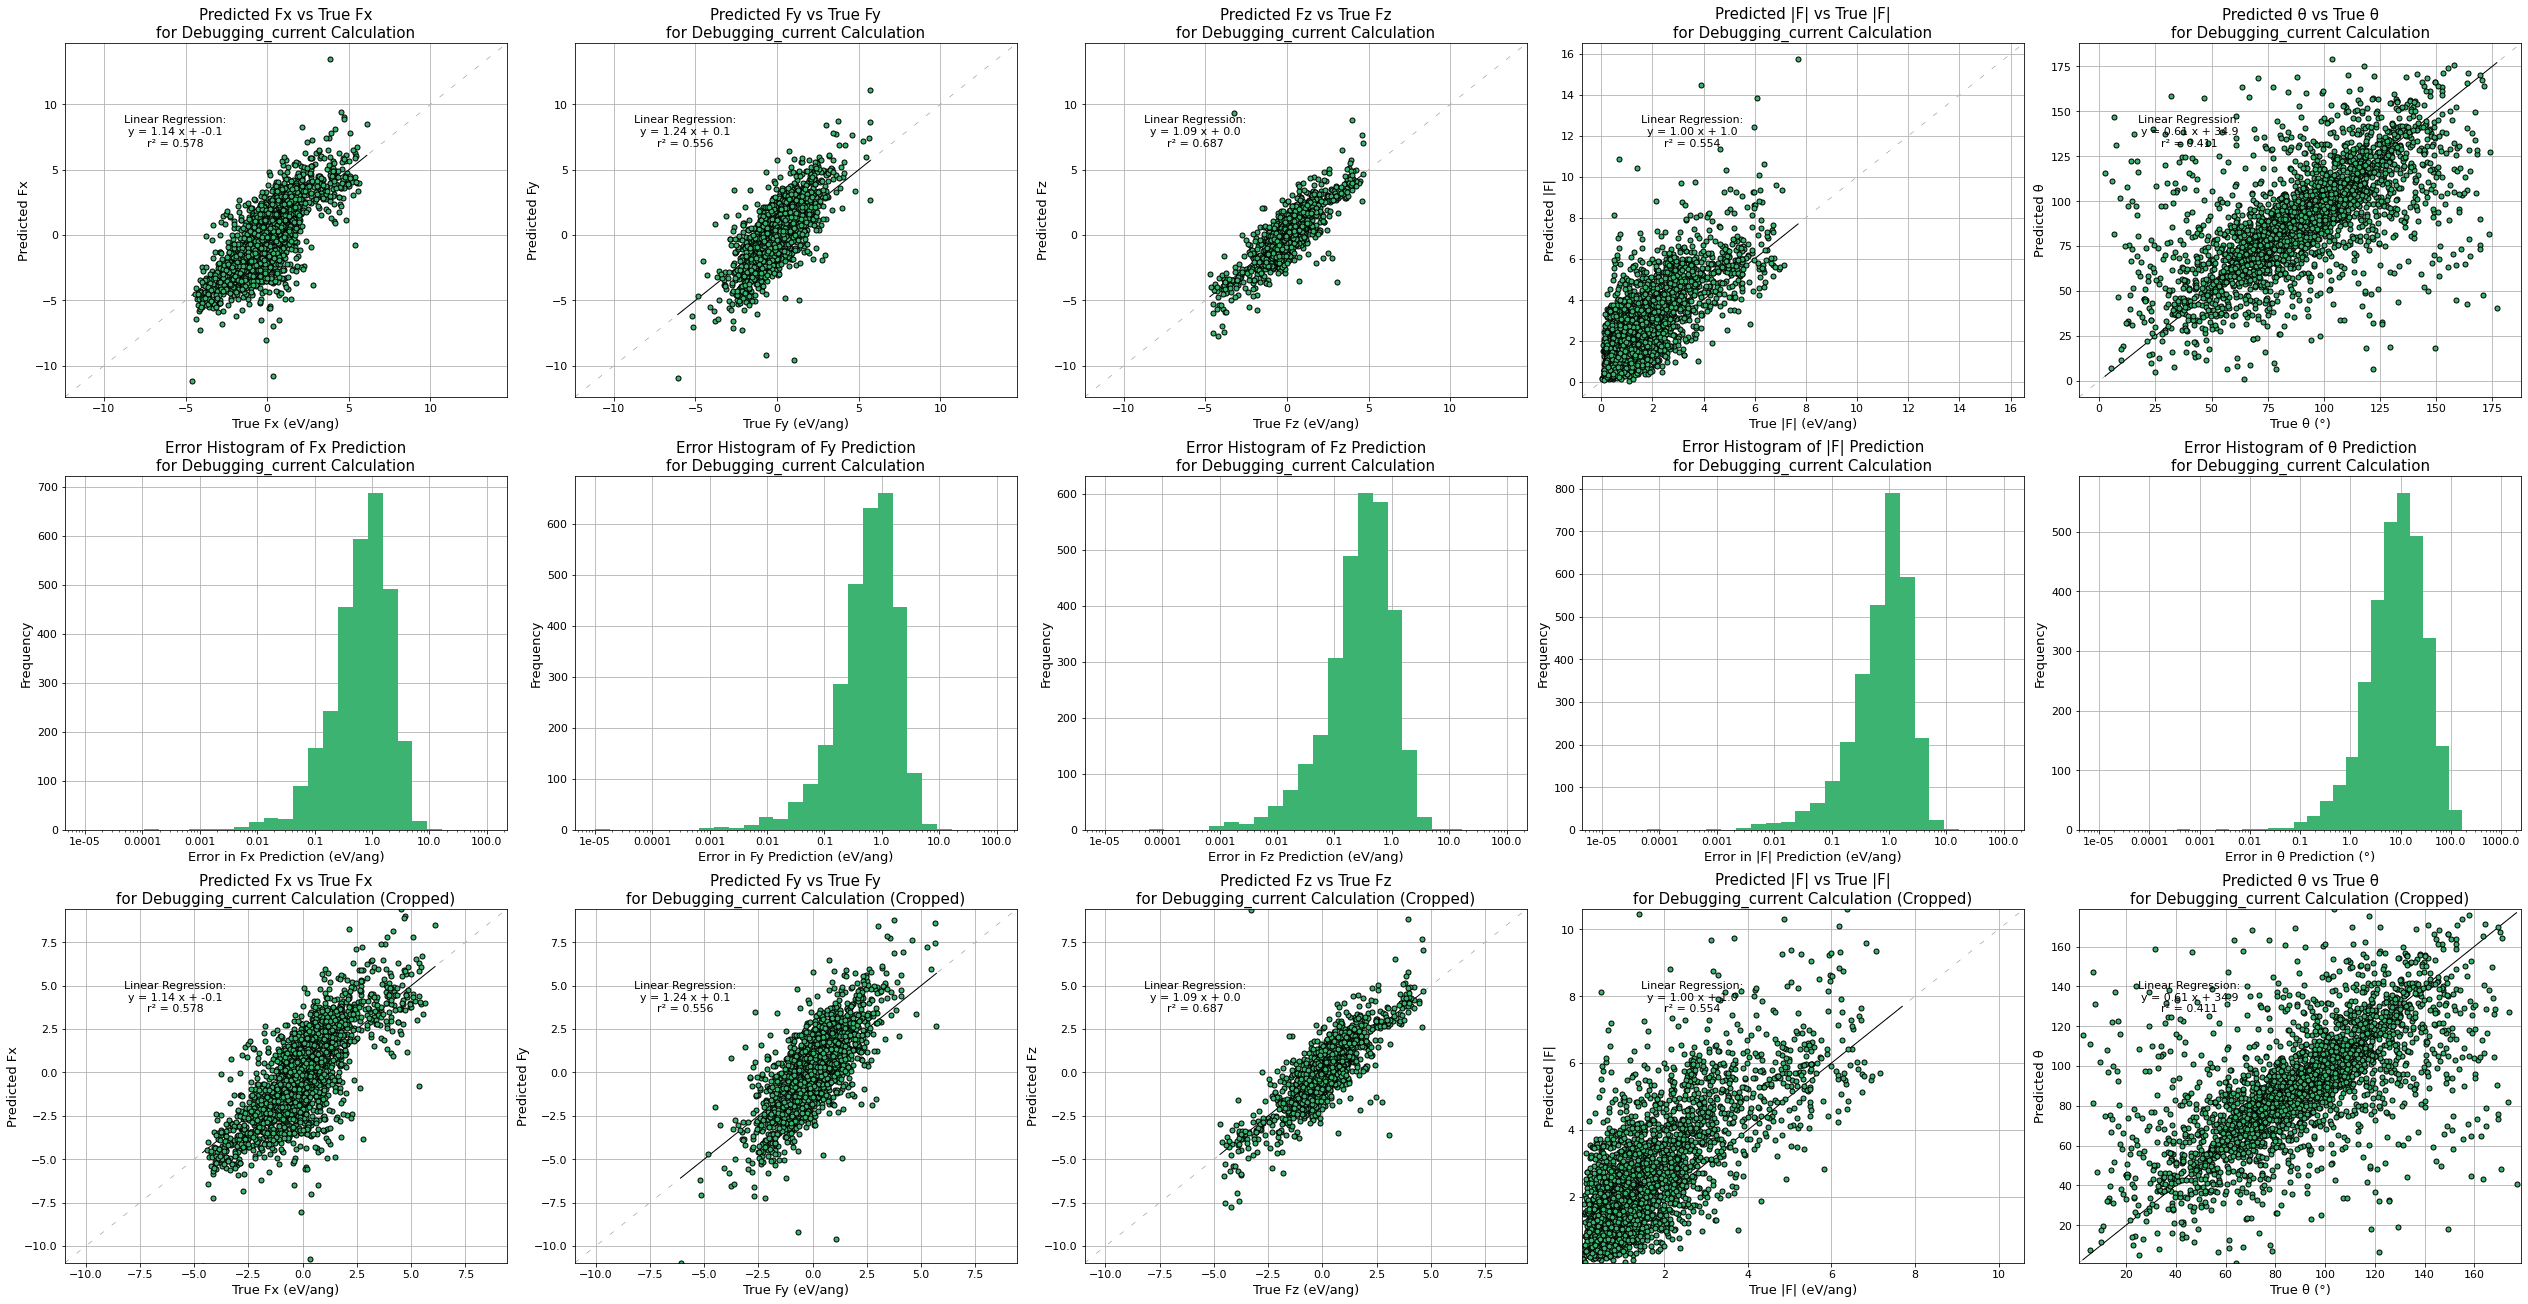

In [27]:
# Creates plots and tables

if s.use_forces:
    AnalyzeForceResults(test_frcs_rescaled, predict_frcs_rescaled, s, predicted_force_stdevs=None, in_notebook=in_notebook,
                        output_directory=calculation_results_directory)

In [28]:
# This closes the log file. Probably not necessary since it is at the end of the script, but it's best practice.
if s.make_output_files and not in_notebook:
    logger.stop()

When converting notebook to script, this line acts as a delimiter. Everything above it will remain. Everything below it will be removed.

# Save as script 

In [29]:
abort_before_saving_script = True
assert not abort_before_saving_script

AssertionError: 

The following cell will save this notebook as a python script with today's date in the code directory

In [30]:
current_notebook_filename = "miniGAP_functional.ipynb"
converted_script_filename = "../code/miniGAP_from_notebook" + today_string 
print("Attempting to convert {} to a notebook.\nIf this fails, check to be sure this notebook is in fact named {}.\n".format(current_notebook_filename, current_notebook_filename))
!jupyter nbconvert --to script "{current_notebook_filename}" --output "{converted_script_filename}"
!sed -i '/When converting notebook to script, this line acts as a delimiter/,$d' "{converted_script_filename}.py"

Attempting to convert miniGAP_functional.ipynb to a notebook.
If this fails, check to be sure this notebook is in fact named miniGAP_functional.ipynb.

[NbConvertApp] Converting notebook miniGAP_functional.ipynb to script
[NbConvertApp] Writing 53035 bytes to ../code/miniGAP_from_notebook_2021_12_17.py


In [ ]:
def isolated_energy_parser(user_input):
    # returns dictionary from input format
    # e.g. "H:-0.4::Li:-7.5" --> {"H":-0.4, "Li":-7.5}
    return {atom_energy.split(":")[0]:float(atom_energy.split(":")[1]) for atom_energy in user_input.split("::")}
a = "H:-0.43796573720365::Li:-7.4538249414114::Be:-14.644518869964::B:-24.512608074927::C:-37.768216780161::N:-54.572189501408::O:-75.003393876879::F:-99.672000678934::Na:-162.20736395632::Mg:-199.4784909209::Al:-241.9640517253::Si:-289.26042225551::P:-341.20691893397::S:-398.04415675952::Cl:-460.04770109924::K:-599.77830261799::Ca:-677.27165785863::Sc:-760.34151748052::Ti:-848.8244251979::V:-943.67762714996::Cr:-1044.1147378511::Mn:-1150.8928446101::Co:-1382.3371803164::Ni:-1508.0647901075::Cu:-1640.1713647787::Zn:-1779.2571044599::Ga:-1924.5685189651::Ge:-2076.7379664988::As:-2235.7034565607::Tc:-4205.5805934383"
isolated_energy_parser(a)